## Dataset creation

* create a training set with all (peptide, CDR3a, CDR3b) publicly available samples

* create a test set with all (peptide, CDR3b) publicly available samples


In [1]:
import pandas as pd
import os
login = os.getlogin( )
BASE = f"/home/{login}/Git/tcr/data/"
FIGURE_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"

# Mcpas (from ERGO II data)

In [2]:
import pickle as p

with open(BASE + "ergo2-paper/mcpas_train_samples.pickle", "rb") as f:
    mcpas_train = pd.DataFrame(p.load(f))

    
with open(BASE + "ergo2-paper/mcpas_test_samples.pickle", "rb") as f:
    mcpas_test = pd.DataFrame(p.load(f))

mcpas = pd.concat([mcpas_train, mcpas_test]).reset_index(drop=True)

In [3]:
# we drop duplicates with `keep=False` because we want to discard samples where binding is
# determined by features which we do not consider e.g. va, ja, vb, jb, t_cell_type, mhc
mcpas_b = mcpas[mcpas["tcra"] == "UNK"][["tcrb", "peptide", "sign"]].drop_duplicates(subset=["tcrb", "peptide"], keep=False)
print(len(mcpas_b))
mcpas_ab = mcpas[mcpas["tcra"] != "UNK"][["tcra", "tcrb", "peptide", "sign"]].drop_duplicates(subset=["tcra", "tcrb", "peptide"], keep=False)
print(len(mcpas_ab))

40688
19022


# Vdjdb (from ERGO II data)

In [4]:
import pickle as p

with open(BASE + "ergo2-paper/vdjdb_train_samples.pickle", "rb") as f:
    vdjdb_train = pd.DataFrame(p.load(f))

    
with open(BASE + "ergo2-paper/vdjdb_test_samples.pickle", "rb") as f:
    vdjdb_test = pd.DataFrame(p.load(f))

vdjdb = pd.concat([vdjdb_train, vdjdb_test]).reset_index(drop=True)

In [5]:
# we drop duplicates with `keep=False` because we want to discard samples where binding is
# determined by features which we do not consider e.g. va, ja, vb, jb, t_cell_type, mhc
vdjdb_b = vdjdb[vdjdb["tcra"] == "UNK"][["tcrb", "peptide", "sign"]].drop_duplicates(subset=["tcrb", "peptide"], keep=False)
print(len(vdjdb_b))
vdjdb_ab = vdjdb[vdjdb["tcra"] != "UNK"][["tcra", "tcrb", "peptide", "sign"]].drop_duplicates(subset=["tcra", "tcrb", "peptide"], keep=False)
print(len(vdjdb_ab))

60741
74930


# MIRA evaluation set (from NetTCR2 data)

In [6]:
mira_b = pd.read_csv(BASE + "nettcr2-paper/mira_eval_threshold100.csv", sep=";")
mira_b = mira_b.rename(columns={"CDR3": "tcrb", "binder": "sign"})
print(len(mira_b))

1152


# IEDB + Vdjdb (alpha+beta from NetTCR2 data)

In [7]:
csv_files = [
    "nettcr2-paper/train_ab_95_alpha.csv",
    "nettcr2-paper/train_ab_95_alphabeta.csv",
    "nettcr2-paper/train_ab_95_beta.csv"
]

iedb_vdjdb_ab = pd.concat([
    pd.read_csv(BASE + csv)
    for csv in csv_files
]).reset_index(drop=True)

iedb_vdjdb_ab = iedb_vdjdb_ab[["CDR3a", "CDR3b", "peptide", "binder"]]
iedb_vdjdb_ab = iedb_vdjdb_ab.rename(columns={"CDR3a": "tcra", "CDR3b": "tcrb", "binder": "sign"})
print(len(iedb_vdjdb_ab))
iedb_vdjdb_ab = iedb_vdjdb_ab.drop_duplicates(subset=["tcra", "tcrb", "peptide"], keep='first')
print(len(iedb_vdjdb_ab))

49392
28755


# IEDB (beta only from NetTCR2 data)

In [8]:
iedb_b = pd.read_csv(BASE + "nettcr2-paper/train_beta_99.csv", sep=";")
iedb_b = iedb_b[["CDR3", "peptide", "binder"]]
iedb_b = iedb_b.rename(columns={"CDR3": "tcrb", "binder": "sign"})
print(len(iedb_b))

55224


# Merging of the datasets

In [9]:
ab_df = pd.concat([
    mcpas_ab,
    vdjdb_ab,
    iedb_vdjdb_ab,
]).reset_index(drop=True)

print(len(ab_df))
# we drop duplicates with `keep=False` because we want to discard samples where there is 
# disagreement about the ground truth label from different datasets 
ab_df = ab_df.drop_duplicates(subset=["tcra", "tcrb", "peptide"], keep=False)
print(len(ab_df))

122707
117753


In [10]:
b_df = pd.concat([
    mcpas_b,
    vdjdb_b,
    mira_b,
    iedb_b
]).reset_index(drop=True)
b_df['tcra'] = "unknown"

print(len(b_df))
# we drop duplicates with `keep=False` because we want to discard samples where there is 
# disagreement about the ground truth label from different datasets 
b_df = b_df.drop_duplicates(subset=["tcrb", "peptide"], keep=False)
print(len(b_df))

157805
153613


In [11]:
117753 + 153613


271366

# Ensure test samples are not in the training set

In [12]:
concat_df = pd.concat([ab_df, b_df])
print(len(concat_df))
concat_df = concat_df.drop_duplicates(subset=["tcrb", "peptide"], keep="first")
print(len(concat_df))

271366
254310


In [13]:
ab_df = concat_df[concat_df["tcra"] != "unknown"]
print("alpha+beta samples: ", len(ab_df))
b_df = concat_df[concat_df["tcra"] == "unknown"]
print("beta samples: ", len(b_df))
print("sum: ", len(ab_df)+len(b_df))

alpha+beta samples:  107775
beta samples:  146535
sum:  254310


In [14]:
ab_df.to_csv(BASE + "alpha-beta-splits/alpha-beta.csv", index=False)
b_df.to_csv(BASE + "alpha-beta-splits/beta.csv", index=False)

# Data exploration

### alpha+beta class distribution

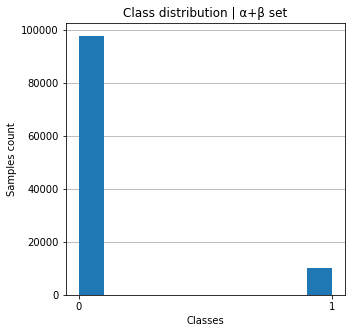

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots()
ab_df.hist(ax=ax, zorder=3)
ax.set_xticks([0,1])
ax.grid(axis='y')

plt.grid(b=None)
plt.ylabel('Samples count')
plt.xlabel('Classes')
plt.title('Class distribution | α+β set')
fig.savefig(FIGURE_BASE + "class-distribution.alpha-beta.png", bbox_inches='tight', dpi=300)
fig.savefig(FIGURE_BASE + "class-distribution.alpha-beta.svg", bbox_inches='tight', dpi=300)

### beta class distribution

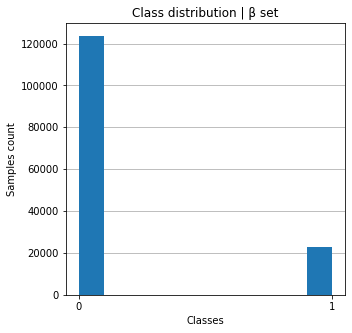

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
b_df.hist(ax=ax, zorder=3)
ax.set_xticks([0,1])
ax.grid(axis='y')
plt.grid(b=None)
plt.ylabel('Samples count')
plt.xlabel('Classes')
plt.title('Class distribution | β set')
fig.savefig(FIGURE_BASE + "class-distribution.beta.png", bbox_inches='tight', dpi=300)
fig.savefig(FIGURE_BASE + "class-distribution.beta.svg", bbox_inches='tight', dpi=300)

### CDR3α distribution analysis

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,3)
plt.rc('axes', axisbelow=True)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

tcra = set(ab_df.tcra.unique())

In [18]:
tcra_count_map = {seq: 0 for seq in tcra}
tmp = ab_df.tcra.value_counts().to_dict()
for i in tmp.keys():
    tcra_count_map[i] += tmp[i]

tcra_count_map = {k: v for k, v in sorted(tcra_count_map.items(), key=lambda item: item[1])}
seq_id_map = {seq: i for i, seq in enumerate(tcra_count_map.keys())}
tcra_count_map = {seq_id_map[seq]: count for seq, count in tcra_count_map.items()}

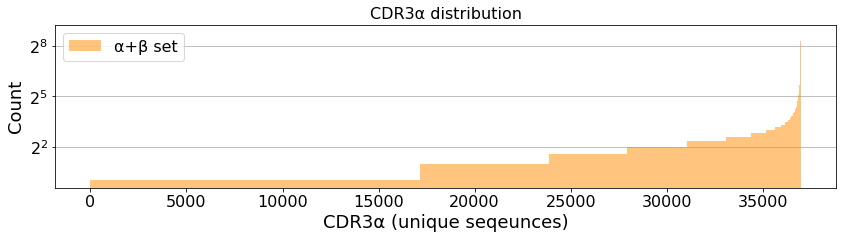

In [19]:
fig, ax = plt.subplots()
plt.bar(tcra_count_map.keys(), tcra_count_map.values(), label="α+β set", color="darkorange", alpha=0.5,width=1.0)

ax.grid(axis='y')
plt.ylabel ('Count')
plt.xlabel ('CDR3α (unique seqeunces)')
plt.legend(loc="upper left")
plt.yscale('log',base=2)
plt.title('CDR3α distribution')
fig.savefig(FIGURE_BASE + "alpha-distribution.png", bbox_inches='tight', dpi=300)
fig.savefig(FIGURE_BASE + "alpha-distribution.svg", bbox_inches='tight', dpi=300)

### CDR3β distribution analysis

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,3)
plt.rc('axes', axisbelow=True)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
tcrb = set(ab_df.tcrb.unique()).union(set(b_df.tcrb.unique()))

In [21]:
tcrb_count_map_ab = {seq: 0 for seq in tcrb}
tmp = ab_df.tcrb.value_counts().to_dict()
for i in tmp.keys():
    tcrb_count_map_ab[i] += tmp[i]


tcrb_count_map_ab = {k: v for k, v in sorted(tcrb_count_map_ab.items(), key=lambda item: item[1])}
seq_id_map = {seq: i for i, seq in enumerate(tcrb_count_map_ab.keys())}
tcrb_count_map_ab = {seq_id_map[seq]: count for seq, count in tcrb_count_map_ab.items()}

In [22]:
tcrb_count_map_b = {seq: 0 for seq in tcrb}
tmp = b_df.tcrb.value_counts().to_dict()
for i in tmp.keys():
    tcrb_count_map_b[i] += tmp[i]


tcrb_count_map_b = {k: v for k, v in sorted(tcrb_count_map_b.items(), key=lambda item: item[1])}
tcrb_count_map_b = {seq_id_map[seq]: count for seq, count in tcrb_count_map_b.items()}

In [23]:
for i in tcrb_count_map_ab.keys():
    frist_non_zero_index_of_ab = i
    first_non_zero_ab = tcrb_count_map_ab[i]
    if first_non_zero_ab > 0:
        break

In [24]:
frist_non_zero_index_of_ab

59932

In [25]:
sequences_in_b_only = []
for i in range(frist_non_zero_index_of_ab):
    sequences_in_b_only.append(tcrb_count_map_b[i])
    sorted_sequences_in_b_only = sorted(sequences_in_b_only)

In [26]:
for i, s in enumerate(sorted_sequences_in_b_only):
    tcrb_count_map_b[i] = s

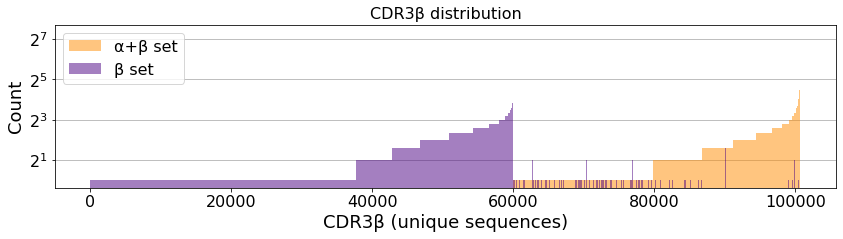

In [27]:
fig, ax = plt.subplots()
plt.bar(tcrb_count_map_ab.keys(), tcrb_count_map_ab.values(), label="α+β set", color="darkorange",alpha=0.5,width=1.0)
plt.bar(tcrb_count_map_b.keys(), tcrb_count_map_b.values(), label="β set", color="indigo", alpha=0.5,width=1.0)

ax.grid(axis='y')
plt.ylabel ('Count')
plt.xlabel ('CDR3β (unique sequences)')
plt.legend(loc="upper left")
plt.yscale('log',base=2) 
plt.title('CDR3β distribution')
fig.savefig(FIGURE_BASE + "beta-distribution.png", bbox_inches='tight', dpi=300)
fig.savefig(FIGURE_BASE + "beta-distribution.svg", bbox_inches='tight', dpi=300)

### Peptide analysis

In [28]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,3)
plt.rc('axes', axisbelow=True)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
peptide = set(ab_df.peptide.unique()).union(set(b_df.peptide.unique()))

In [29]:
peptide_count_map_ab = {seq: 0 for seq in peptide}
tmp = ab_df.peptide.value_counts().to_dict()
for i in tmp.keys():
    peptide_count_map_ab[i] += tmp[i]


peptide_count_map_ab = {k: v for k, v in sorted(peptide_count_map_ab.items(), key=lambda item: item[1])}
seq_id_map = {seq: i for i, seq in enumerate(peptide_count_map_ab.keys())}
peptide_count_map_ab = {seq_id_map[seq]: count for seq, count in peptide_count_map_ab.items()}

In [30]:
peptide_count_map_b = {seq: 0 for seq in peptide}
tmp = b_df.peptide.value_counts().to_dict()
for i in tmp.keys():
    peptide_count_map_b[i] += tmp[i]


peptide_count_map_b = {k: v for k, v in sorted(peptide_count_map_b.items(), key=lambda item: item[1])}
peptide_count_map_b = {seq_id_map[seq]: count for seq, count in peptide_count_map_b.items()}

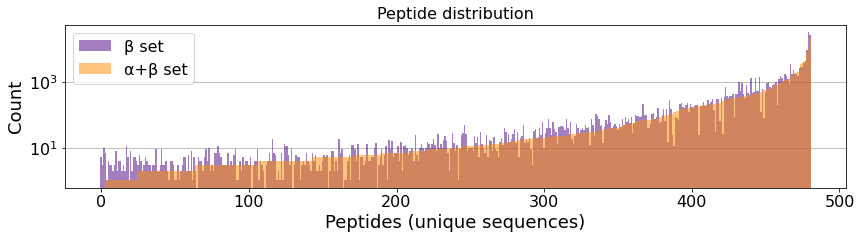

In [31]:
fig, ax = plt.subplots()
plt.bar(peptide_count_map_b.keys(), peptide_count_map_b.values(), label="β set", color="indigo", alpha=0.5, width=1.0)
plt.bar(peptide_count_map_ab.keys(), peptide_count_map_ab.values(), label="α+β set", color="darkorange", alpha=0.5, width=1.0)

ax.grid(axis='y')
plt.ylabel('Count')
plt.xlabel('Peptides (unique sequences)')
plt.legend(loc="upper left")
plt.yscale('log',base=10)
plt.title('Peptide distribution')
fig.savefig(FIGURE_BASE + "peptide-distribution.png", bbox_inches='tight', dpi=300)
fig.savefig(FIGURE_BASE + "peptide-distribution.svg", bbox_inches='tight', dpi=300)